# Simulate Euclid Images Using HST Ones

In this notebook, we are going to simulate step by a Euclid space telescope image using a HST one.

First things first, we start by preparing the worksapce.

In [1]:
# to correctly show figures
%matplotlib inline

# import libraries here
import galsim
import numpy as np
import matplotlib.pyplot as plt

Here we are going to load the Euclid and HST required parameters.
> Euclid telescope specifications can be found [here](https://github.com/LSSTDESC/WeakLensingDeblending/blob/9f851f79f6f820f815528d11acabf64083b6e111/descwl/survey.py#L366).

In [2]:
pixel_scale = 0.101
wcs = galsim.wcs.PixelScale(pixel_scale) #wcs: world coordinate system. Variable used to draw images in galsim
lam = 700  # nm
diam = 1.3    # meters
lam_over_diam = (lam * 1.e-9) / diam  # radians
lam_over_diam *= 206265  # Convert to arcsec
exp_time = 2260# exposure time
euclid_eff_area = 1.15 #effective area

Load the [COSMOS](https://github.com/GalSim-developers/GalSim/wiki/RealGalaxy%20Data) catalog and generate a galaxy and a PSF.

In [3]:
catalog = galsim.COSMOSCatalog() # load catalog
img_len = 64 # arbitrary value, practical because power of 2
gal_ind = 133 # galaxy index in the catalog
gal = catalog.makeGalaxy(gal_ind, noise_pad_size=img_len * pixel_scale * np.sqrt(2))
psf = galsim.OpticalPSF(lam=lam, diam=diam, scale_unit=galsim.arcsec)

Now that we have loaded a galaxy from the catalog, let's rescale its flux such that it corresponds to a Euclid flux.

> Flux rescaling formula telescope specifications can be found [here](https://github.com/GalSim-developers/GalSim/blob/releases/2.2/examples/demo11.py#L110).

In [4]:
hst_eff_area = 2.4**2 * (1.-0.33**2)
flux_scaling = (euclid_eff_area/hst_eff_area) * exp_time
gal *= flux_scaling

Apply the simulated Euclid PSF on the galaxy image.

In [5]:
gal = galsim.Convolve(gal, psf)

Let's have a look at the galaxy and the PSF. In the galaxy image, noted $X$, we try to visually separate the noise (which standard deviation is noted $\sigma$) from the useful signal by applying the following transform:
\begin{equation}
\text{ArcSinh}\left(\frac{X}{k\sigma}\right).k\sigma
\end{equation}
> <b>Technical precision:</b> Usually the noise standard deviation is usually estimated with more accurate methods such as using a window to mask the galaxy then estimate the standard deviation on the rest of the samples which only contain noise. For sake of simplicity, in this example, we only considered an area of the image that only contains noise and estimated the noise standard deviation in it.

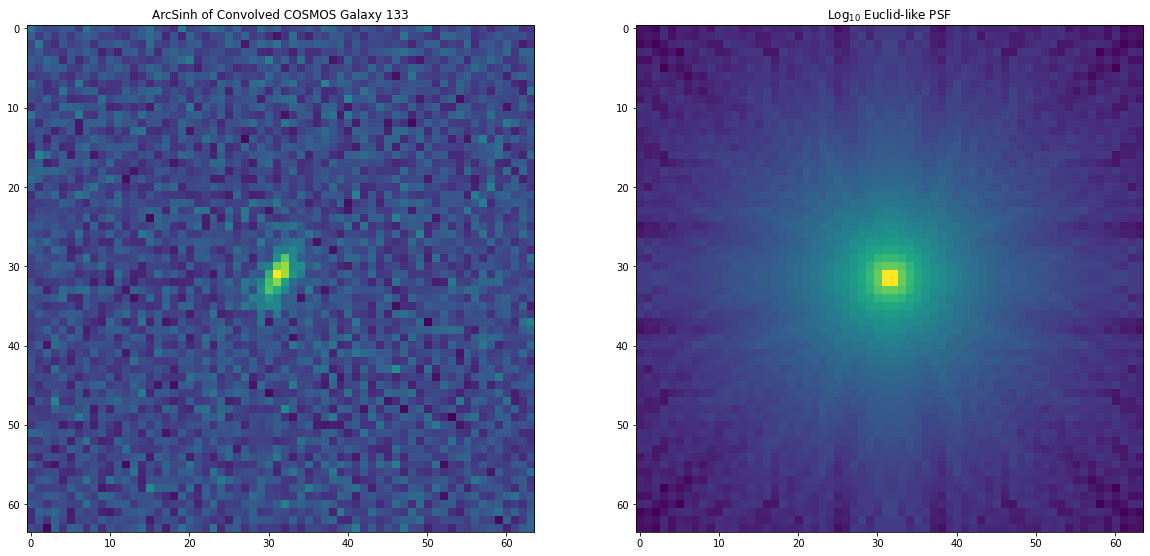

In [6]:
# Get the standard deviation value of the noise for real images
gal_im = gal.drawImage(wcs=wcs, nx=img_len,ny=img_len)
# Empirically estimate the standard deviation by considering a part of the image containing only noise
hst_std = np.std(gal_im.array[0:25,0:25])

k=4

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.title('ArcSinh of Convolved COSMOS Galaxy {}'.format(gal_ind))
plt.imshow(np.arcsinh(gal_im.array/(k*hst_std))*k*hst_std)
plt.subplot(122)
plt.imshow(np.log10(psf.drawImage(wcs=wcs, nx=img_len,ny=img_len).array))
plt.title(r'Log$_{10}$ Euclid-like PSF')
plt.show()

The noise that we see in image above corresponds to HST noise (which is also correlated due to the division by the HST PSF and the multiplication by the Euclid-like one), we are going to adapt this noise to Euclid. First we compute Euclid global noise standard deviation. 

To do so, we compute $\lambda$ (in electrons per pixel), the Poisson parameter of the noise and aprroximate it with a white Gaussian noise such that its standard deviation is $\sqrt{\lambda}$.

> The $\lambda$ parameter corresponds to the `mean_sky_level` which expression can be find [here](https://github.com/LSSTDESC/WeakLensingDeblending/blob/9f851f79f6f820f815528d11acabf64083b6e111/descwl/survey.py#L110)

In [7]:
def get_flux(ab_magnitude):
    zero_point = 6.85
    return exp_time*zero_point*10**(-0.4*(ab_magnitude-24))

sky_brightness = 22.9207
pixel_scale = 0.101
mean_sky_level = get_flux(sky_brightness)*pixel_scale**2 # it is the Poisson noise parameter

sigma = np.sqrt(mean_sky_level) # we modelize the noise as a Gaussian noise such that it std
                                # is the sqrt of the Poisson parameter
print('Euclid global noise standard deviation: {:.2f}'.format(sigma))

Euclid global noise standard deviation: 20.66


Then we estimate the value of HST noise standard deviation and we take it into to account while adding the noise such that we end up with Euclid noise standard deviation.
> <b>Reminder:</b> For any independent random variables, the variance of the sum of those variables is equal to the sum of the variances.

In [8]:
# Add noise
delta_std = np.sqrt(sigma**2 - hst_std**2)
random_seed = 24783923 #same as galsim demo 11
noise = galsim.GaussianNoise(galsim.BaseDeviate(random_seed), sigma=delta_std)
gal_im.addNoise(noise)
image = gal_im.array

Now that we simulated the Euclid observed image, let's show it and estimate its noise standard deviation as a check.

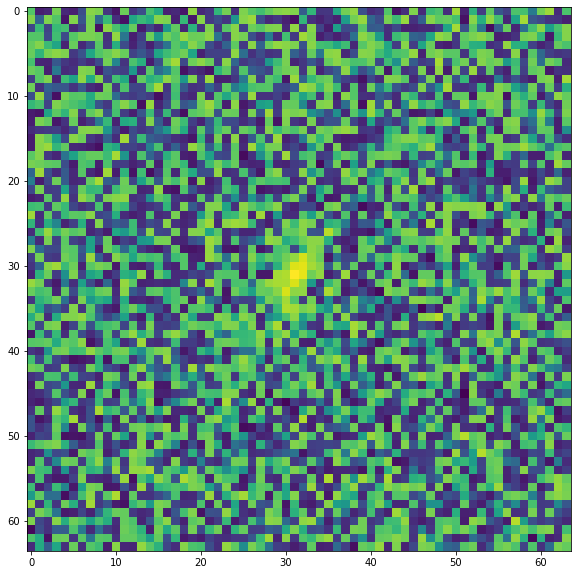

Standard Deviation Value of Euclid Simulated Image: 20.66


In [9]:
plt.figure(2, figsize=(10,10))
plt.imshow(image)
plt.imshow(np.arcsinh(image/(k*sigma)*k*sigma))
plt.show()
print('Standard Deviation Value of Euclid Simulated Image: {:.2f}'.format(np.std(image[0:25,0:25])))